# Lab 5  - WFST operations

So far we've used WFSTs mainly as a usual structure for encoding and traversing HMMs.  In this lab we'll move away from HMM acoustic modelling and look at how WFST operations can be used to avoid the need for specialised algorithms in speech and language processing.  It is intended to give you insight into how these operations are used to construct HMMs encapsulating langauge model, pronunciation and acoustic modelling assumptions &ndash; the so-called "HCLG" WFST.

This lab will focus on the lexicon transducer, $L$, and grammar transducer, $G$.

We'll use some of the following operations, defined by Openpynini:
* `pynini.determinize(f)` creates determinized version of `f`
* `pynini.compose(f1,f2)` composes FSTs `f1` and `f2`
* `pynini.shortestpath(f)` returns the shortest path (in terms of weight) through `f` from the start to a final state
* `f.minimize()` creates minimized version of `f`
* `f.project('output')` for every arc in `f`, copies the input label to the output label (or vice versa, if `'input'` is passed).
* `f.rmepsilon()` removes epsilon transitions &ndash; those arcs where both input and output labels are empty.

For efficiency, the compostion of `f1` and `f2` requires either the output arcs of `f1` or input arcs of `f2` to be sorted prior to `compose()` being called.  You can do this by calling `f1.arcsort(sort_type='olabel')` or `f2.arcsort(sort_type='ilabel')`.

Combining projection and removal of epsilon transitions will give you better visual clarity when looking at your FSTS.

The functions above assume that `pynini` has been imported.  Note that the first three functions above return a new WFST; the others modify the WFST *in place*, meaning that the original WFST is modified directly.

For convenience, we've provided a python module `helper_functions` that provides the `parse_lexicon()` and `generate_symbol_tables()` from the [Lab 1 solutions](https://github.com/Ore-an/asr_lab1/blob/master/asr_lab1_solutions.ipynb).  And here is a function to generate an $L$ transducer:

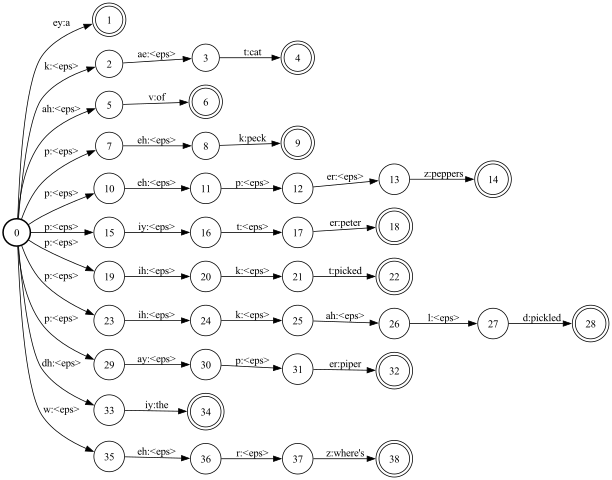

In [7]:
import pynini
from helper_functions import parse_lexicon, generate_symbol_tables

lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)  # we won't use state_table in this lab
eps = phone_table.find('<eps>')

def generate_L_wpynini(lex):
    """ Express the lexicon in WFST form
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
    
    Returns:
        the constructed lexicon WFST
    
    """
    L = pynini.Fst()
    
    # create a single start state
    start_state = L.add_state()
    L.set_start(start_state)
    
    for (word, pron) in lex.items():
        
        current_state = start_state
        for (i,phone) in enumerate(pron):
            next_state = L.add_state()
            
            if i == len(pron)-1:
                # add word output symbol on the final arc
                L.add_arc(current_state, pynini.Arc(phone_table.find(phone), \
                                                 word_table.find(word), None, next_state))
            else:
                L.add_arc(current_state, pynini.Arc(phone_table.find(phone),0, None, next_state))
            
            current_state = next_state
                          
        L.set_final(current_state)
        
    L.set_input_symbols(phone_table)
    L.set_output_symbols(word_table)                      
    
    return L

L = generate_L_wpynini(lex)
L.arcsort()

For the exercises, here are two functions to generate linear WFSTs for an arbitary sequence of phones or words.  (Yes, they are really just variants of the same function!)

In [8]:
def generate_linear_phone_wpynini(phone_list):
    
    P = pynini.Fst()
    
    current_state = P.add_state()
    P.set_start(current_state)
    
    for p in phone_list:
        
        next_state = P.add_state()
        P.add_arc(current_state, pynini.Arc(phone_table.find(p), phone_table.find(p), None, next_state))
        current_state = next_state
        
    P.set_final(current_state)
    P.set_input_symbols(phone_table)
    P.set_output_symbols(phone_table)
    return P
    
def generate_linear_word_wpynini(word_list):
    
    W = pynini.Fst()
    
    current_state = W.add_state()
    W.set_start(current_state)
    
    for w in word_list:
        
        next_state = W.add_state()
        W.add_arc(current_state, pynini.Arc(word_table.find(w), word_table.find(w), None, next_state))
        current_state = next_state
        
    W.set_final(current_state)
    W.set_input_symbols(word_table)
    W.set_output_symbols(word_table)
    return W

## Exercises

1. Suppose you are given a sequence of phones, in the form `['p','ih','k','t']`, and the $L$ transducer created above.  Write a function that returns the matching word from the lexicon for any given phone sequence, or else `None` if no matching word is found.   Write two functions:
  1. That works for $L$ as provided by the code above
  2. That works only on a determinized version of $L$ &ndash; and test it on the output of `pynini.determinize(L)`
  
 This should enable you to see why determinization is a very useful WFST operation!
  


In [11]:
import math

def transduce_sequence_nondet(f, in_seq):
    """Return transduced sequence given input sequence and non determinized FST.
        Note that our skeleton code uses a queue to traverse the FST.
        You can change this if you prefer, as long as you correctly output the list of trasduced words.
    
        Args:
            f (pynini.Fst()): a non determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(in_seq)
    in_seq.append('<EOS>') # adding a padding symbol at the end for possible final eps traversal
    queue = [(f.start(), 0, [])]  # the tuple is (state, index in input sequence, output)
    outputs = []
    
    while queue:
        curr_state, i, output = queue.pop(0) # pop first element in list
        
        if i <= seq_len:  # <= because we could traverse epsilons even when the input sequence ended
            
            # Your code here
            
        if i == seq_len:
            final_weight = float(f.final(curr_state))
            if final_weight != math.inf: # if this is a final state
                out_seq = [f.output_symbols().find(w) for w in output if w != eps]  # find the labels in the table, remove epsilons
                return out_seq
            
        
    print("Can't transduce the sequence with provided FST")  # return exits the function, so this is printed only when the stack is empty and we didn't find a path 

IndentationError: expected an indented block (3690357683.py, line 28)

In [ ]:
seq = ['p','ih','k','t']
print(transduce_sequence_nondet(L, seq))

In [ ]:
#You should see the result below after running the last block
# ['picked']

In [ ]:
def transduce_sequence_det(f, seq):
    """Return transduced sequence given input sequence and determinized FST
    
        Args:
            f (pynini.Fst()): a determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(seq)
    curr_state = f.start()
    output = []
    
    for i in range(seq_len):
        # Your code here
    final_weight = float(f.final(curr_state))
    if final_weight != math.inf: # if this is a final state
        out_seq = [f.output_symbols().find(w) for w in output if w != eps]  # find the labels in the table, remove epsilons
        return out_seq
    else:  
        print("Can't transduce the sequence with provided FST")

In [ ]:
seq = ['p','ih','k','t']
Ldet = pynini.determinize(L)
print(transduce_sequence_det(Ldet, seq))

NameError: name 'transduce_sequence_det' is not defined

In [ ]:
# You should see the result below after running the last block
# ['picked']

2. WFST composition allows you to achieve the same result much more easily.  Create a linear WFST, $P$, corresponding to a string of phones, and compute $P \circ L$.  Then use the projection and epsilon removal operations to display just the matching word.

In [ ]:
seq = ['p','ih','k','t']
P = generate_linear_phone_wpynini(seq)

def compose_phone_sequence_with_lexicon(P, L):

    # Your code here for composition of P and L and other necessary FST operations
    
    return comp

comp = compose_phone_sequence_with_lexicon(P, L)
comp

You should see this figure after running the last block
![compose_phone_sequence_with_lexicon](figs/compose_phone_sequence_with_lexicon.png)

3. Modify your lexicon WFST slightly to allow a list of phones to be "decoded" to a sequence of multiple words from the lexicon. Then, compose the modified lexicon with a sequence of phones of multiple concatenated words.  Try it with `['p','eh','k','ah','v','p','iy','t','er']`.  

In [10]:
# this modified the Lexicon WFST directly - you can also do it by adding
# extra code to the generate_L_wpynini() function above
# The code below enables L to decode a sequence of phones corresponding to multiple words

start_state = L.start()
for state in L.states():
    if float(L.final(state)) != math.inf:
        L.add_arc(state, pynini.Arc(0, 0, None, start_state))  # add arc to start
Ldet = pynini.determinize(L)

NameError: name 'math' is not defined

In [ ]:
seq = ['p','eh','k','ah','v','p','iy','t','er']
P = generate_linear_phone_wpynini(seq)

def compose_phone_sequences_with_lexicon(P, L):
    

    # Your code here for composition of P and L and other necessary FST operations
    
    return comp

comp = compose_phone_sequences_with_lexicon(P, L)
comp

You should see this figure after running the last block
![compose_phone_sequences_with_lexicon](figs/compose_phone_sequences_with_lexicon.png)

4. Now solve the reverse problem: create a word-sequence WFST, $W$, and use composition to expand it into a sequence of phones. You'll need to sort by output labels this time.

In [ ]:
seq = ['peck', 'of', 'peter']
W = generate_linear_word_wpynini(seq)

def compose_lexicon_with_word_sequence(L, W):
    
    # Your code here
    return comp

comp = compose_lexicon_with_word_sequence(L, W)
comp

You should see this figure after running the last block
![compose_lexicon_with_word_sequence](figs/compose_lexicon_with_word_sequence.png)

5. Another advantage of WFST composition to solve these kind of problems are that it is easy to encode uncertainty in the input (a bit like in real ASR).  For example, consider this WFST, in which the multiple arcs denote alternative phone transcriptions from the acoustic model:

In [ ]:
def create_alt_phone_wpynini(phone_alternatives):
    
    P = pynini.Fst()
    
    current_state = P.add_state()
    P.set_start(current_state)
    
    for alt in phone_alternatives:
        
        next_state = P.add_state()
        for p in alt:
            if p=='*':
                P.set_final(current_state)
            else:
                P.add_arc(current_state, pynini.Arc(phone_table.find(p), phone_table.find(p), None, next_state))
        current_state = next_state
        
    P.set_final(current_state)
    P.set_input_symbols(phone_table)
    P.set_output_symbols(phone_table)
    return P    
    
altP = create_alt_phone_wpynini([['p'],['ay'],['p'],['er'],['p'],['eh','ih'],['k'],['t','<eps>'],['ah','<eps>'],['l','v','*'],['d','*']])
altP

  Again, perform composition with your $L$ from Question 3, and observe the result.  (Notice particularly what happens to the `<eps>` transitions during composition.  

In [ ]:
altP.arcsort()
comp = # Please compose altP and L here 
comp

You should see this figure after running the last block
![compose_altP_lexicon](figs/compose_altP_lexicon.png)

In [ ]:
uncertainP = # Please project the output labels and remove epsilons here 
uncertainP

You should see this figure after running the last block
![project_output.png](figs/project_output.png)

6. We could have added weights to the arcs of the WFST above to describe the probability of the phone alternatives given by the acoustic model &ndash; this would have enabled you to find the most likely sequence of words.  Without this information, let's instead use a $G$ WFST to find the most likely sequence.  Let's assume that a word sequence taken from the passage "peter piper picked a peck of pickled peppers" is most likely.  Design a $G$ WFST that accepts any sequence of words from the lexicon, but adds a cost of 1.0 to any word transition not in the passage.  Given $G$, use composition to recover the most likely word sequence from the uncertain $P$.

In [ ]:
def generate_G_wpynini(wseq):
    """ Generate a grammar WFST that accepts any sequence of words for words in a sentence.
        Word transitions not present in the sentence have a cost of 1, while those present have a cost of 0. 
        Args:
            wseq (str): the sentence to use
        Returns:
            W (pynini.Fst()): the grammar WFST """
    
    G = pynini.Fst()
    start_state = G.add_state()
    G.set_start(start_state)
    
    prev_state = None
    
    for w in wseq.split():
        current_state = G.add_state()

        # Your code here
    
    G.set_final(start_state)
        
    G.set_input_symbols(word_table)
    G.set_output_symbols(word_table)  
 
    return G

string = "peter piper picked a peck of pickled peppers"
G = generate_G_wpynini(string)
G
    

Now take the composition of the alternative pronunciation sequence and L you did in the exercise before and compose it with your new grammar. Check the output of the shortest path.

In [ ]:
# Composition with your G wpynini

G.arcsort(sort_type='olabel')
comp = pynini.compose(uncertainP, G)
comp.rmepsilon()

You should see something similar to this
![compose_with_G](figs/compose_with_G.png)

In [ ]:
# Get your result
pynini.shortestpath(comp)

You should see this figure after running the last block
![results.png](figs/results.png)

## If you have more time

Use WFST composition to implement a "predictive text"-style algorithm, that, given a partial phone sequence such as `['p']` or `['p','ih']`, returns a WFST giving all matching words.  You'll need to make some special modifications to $P$ or $L$, or both. On a determinized $L$ transducer this is a highly efficient way of solving this problem.

In [ ]:
# There are very many ways this problem can be solved. Our skeleton code add extra arcs with 
# special <rho> symbol. This symbol will represent unterminated sequences, and will be transduced
#  to words to be output at every intermediate state.
# The same <rho> symbol is added the end of the partial pronunciation.

def generate_predictive_L_wpynini(lex):
    """ express the lexicon in WFST form s.t. composition with partial sequence gives matching words
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
    
    Returns:
        the constructed WFST
    
    """
    Lpred = pynini.Fst()
    rho = phone_table.add_symbol('<rho>')
    # create a single start state
    start_state = Lpred.add_state()
    Lpred.set_start(start_state)
    
    for (word, pron) in lex.items():
        
        # Your code here
        
    Lpred.set_input_symbols(phone_table)
    Lpred.set_output_symbols(word_table)                      
    
    return Lpred

Lpred = generate_predictive_L_wpynini(lex)
Lpred.arcsort()

In [ ]:
seq = ['p']
seq += ['<rho>']
Ppred = generate_linear_phone_wpynini(seq)
Ppred.arcsort(sort_type='ilabel')
comp = pynini.compose(Ppred, Lpred)
comp.project('output').rmepsilon()